In [9]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd

num_group_of_4 = 9  # Number of groups with 4 members
num_group_of_3 = 1  # Number of groups with 3 members
input_file = 'aip-clustering/authors_list_full.csv'

# minimization = True
minimization = False
const_ifmember = True
# const_ifmember = False

df = pd.read_csv(input_file)
df_attendees = df[df['absence'] == 0].reset_index(drop=True)

N = df_attendees.shape[0]
G = num_group_of_4 + num_group_of_3
assert N == num_group_of_4 * 4 + num_group_of_3 * 3, "The total number of points does not match the total group sizes."

group_sizes = [4]*num_group_of_4 + [3]*num_group_of_3  # List of group sizes
points = range(N)
groups = range(G)

author_names = df_attendees['author'].values
coordinates = df_attendees[['x_coordinate', 'y_coordinate']].values
x_coords = coordinates[:, 0]
y_coords = coordinates[:, 1]
ifmember_values = df_attendees['ifmember'].values

# Calculate distance matrix
D = np.zeros((N, N))
for i in points:
    for j in points:
        D[i, j] = np.hypot(x_coords[i] - x_coords[j], y_coords[i] - y_coords[j])

# Create model
m = gp.Model("Grouping")

# Set time limit to 10 minutes
m.setParam('TimeLimit', 600) 

# Decision variables x_{i,k}
x = m.addVars(points, groups, vtype=GRB.BINARY, name="x")

# Set objective function
obj = gp.quicksum(D[i, j] * x[i, k] * x[j, k] * 0.5
                  for k in groups for i in points for j in points if i != j)
m.setObjective(obj, GRB.MINIMIZE if minimization else GRB.MAXIMIZE)

# Constraint 1: Each point is assigned to exactly one group
for i in points:
    m.addConstr(gp.quicksum(x[i, k] for k in groups) == 1, name=f"Assign_{i}")

# Constraint 2: Each group has the specified number of points
for k in groups:
    m.addConstr(gp.quicksum(x[i, k] for i in points) == group_sizes[k], name=f"GroupSize_{k}")

if const_ifmember:
    # Constraint 3: Limit the number of `ifmember` to at most 1 in each group
    for k in groups:
        m.addConstr(gp.quicksum(x[i, k] * ifmember_values[i] for i in points) <= 1, name=f"IfMemberLimit_{k}")

# Optimize
m.optimize()

Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Academic license 2565624 - for non-commercial use only - registered to ur___@g.ecc.u-tokyo.ac.jp
Optimize a model with 59 rows, 390 columns and 850 nonzeros
Model fingerprint: 0xba97eacd
Model has 7410 quadratic objective terms
Variable types: 0 continuous, 390 integer (390 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve time: 0.01s
Presolved: 7469 rows, 7800 columns, 23080 nonzeros
Variable types: 0 continuous, 7800 integer (7800 binary)

Interrupt request received
Found heuristic solution: objective 135.7326413

Root relaxation: objective 1.568585e

In [10]:
group_assignments = []

for k in groups:
    group_points = [i for i in points if x[i, k].X > 0.5]
    group_authors = author_names[group_points]
    for i in group_points:
        group_assignments.append({'author': author_names[i], 'group': k+1})

group_assignments_df = pd.DataFrame(group_assignments)
group_assignments_df.to_csv(f'aip-clustering/group_assignments_{"min" if minimization else "max"}_{"member_distributed" if const_ifmember else ""}.csv', index=False)


Group 1:
 Point IDs: [15, 17, 18, 33]
 Names: ['Shimizu Takafumi' 'Tokio Takada' 'Tomoki Ono' 'Hiroyuki Hanada']
 Total distance within group: 18.191300756117524

Group 2:
 Point IDs: [0, 11, 12, 14]
 Names: ['Mika Oki' 'Seiji Shimizu' 'Tatsuya Kubo' 'Takashi Nomoto']
 Total distance within group: 16.705624975002568

Group 3:
 Point IDs: [4, 9, 23, 27]
 Names: ['Hanrui Wang' 'Alex Orsholits' 'Kaysar Md Nadim' 'Miyagi Ryota']
 Total distance within group: 17.532523994089228

Group 4:
 Point IDs: [2, 6, 7, 8]
 Names: ['Yoshiki WATANABE' 'Kyosuke Hatsugai' 'Noriaki Hashimoto' 'Sato Motoaki']
 Total distance within group: 15.967250965446276

Group 5:
 Point IDs: [1, 25, 26, 31]
 Names: ['Yusuke Sugizaki' 'Kousei Ohtsuka' 'Ayaka Mito' 'Taku Imaizumi']
 Total distance within group: 16.503411374389934

Group 6:
 Point IDs: [20, 21, 34, 37]
 Names: ['AprilPyoneMaungMaung' 'Awane Aika' 'Hiroyoshi Ito' 'Yuki Ogasawara']
 Total distance within group: 12.59696511568742

Group 7:
 Point IDs: [3, 5

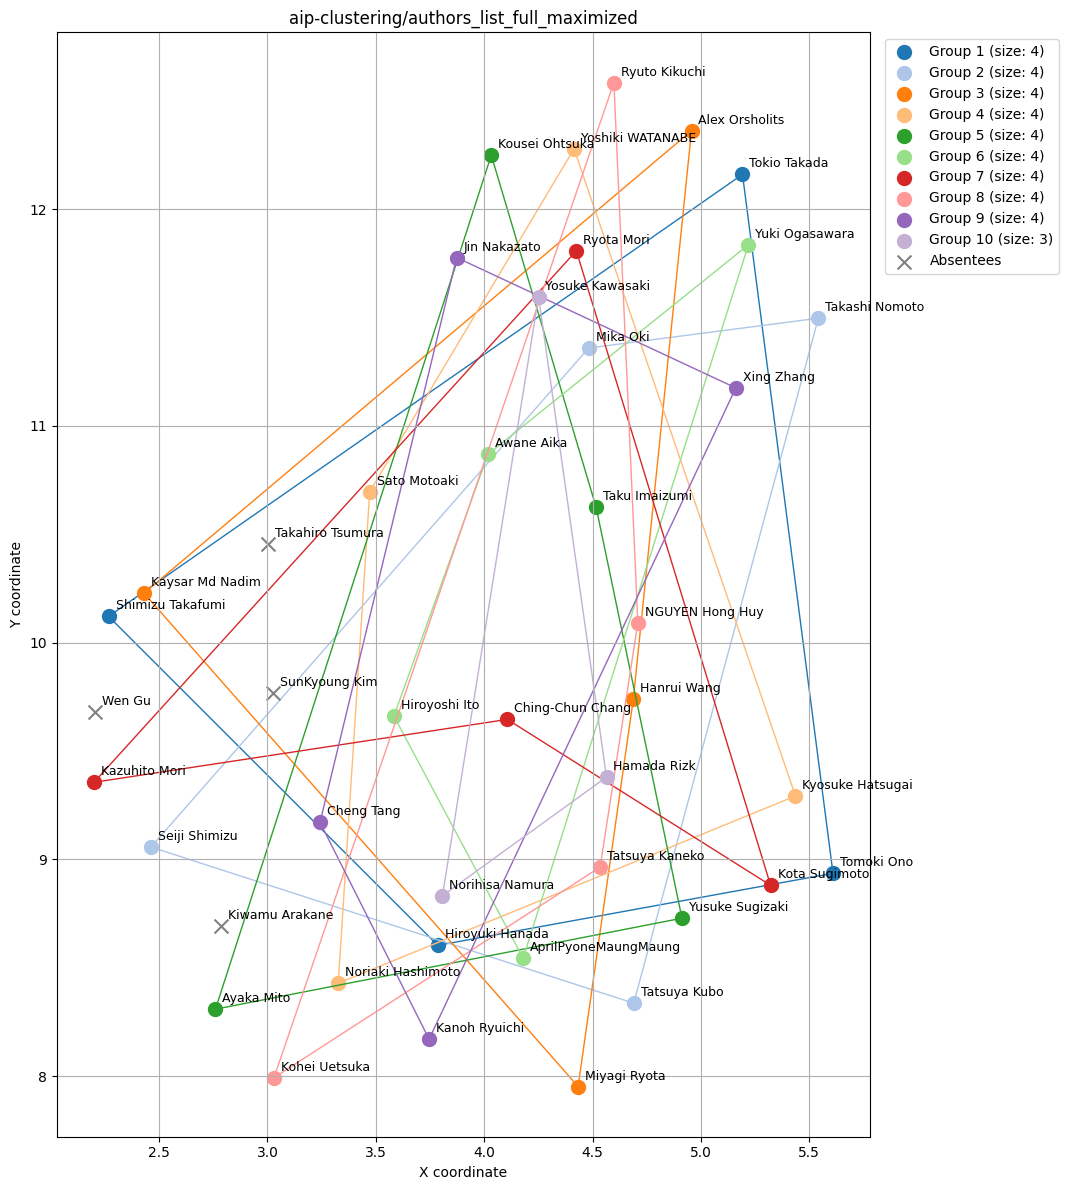

In [11]:
import matplotlib.pyplot as plt


# Set up group_color map
cmap = plt.get_cmap('tab20')  # 20 colors
colors = [cmap(i) for i in range(G)]
absentee_color = 'gray'
# 図と軸を作成（アスペクト比を等しく設定）
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal', 'box')

# グループごとに出席者をプロット
for k in groups:
    group_points = [i for i in points if x[i, k].X > 0.5]
    group_coords = coordinates[group_points]
    group_names = author_names[group_points]
    group_color = colors[k % len(colors)]

    # グループのポイントをプロット
    ax.scatter(group_coords[:, 0], group_coords[:, 1], c=[group_color], s=100, label=f'Group {k+1} (size: {group_sizes[k]})')
    # 各ポイントに著者名を注釈
    for idx, txt in zip(group_points, group_names):
        ax.annotate(txt, (x_coords[idx], y_coords[idx]), fontsize=9, xytext=(5,5), textcoords='offset points')

    if minimization:
        # グループの重心を計算
        centroid = np.mean(group_coords, axis=0)
        # 重心から各ポイントへの距離を計算し、最大距離を取得
        distances = np.linalg.norm(group_coords - centroid, axis=1)
        radius = np.max(distances)
        # グループの周りに円を描画
        circle = plt.Circle((centroid[0], centroid[1]), radius, color=group_color, fill=False, linestyle='-')
        ax.add_artist(circle)
        # 重心をプロット
        ax.scatter(centroid[0], centroid[1], c=[group_color], marker='x', s=200)
    else:
        # グループ内のポイントを角度でソート
        center = np.mean(group_coords, axis=0)
        angles = np.arctan2(group_coords[:, 1] - center[1], group_coords[:, 0] - center[0])
        sorted_indices = np.argsort(angles)
        # グループの凸包をプロット
        polygon_coords = group_coords[sorted_indices]
        polygon = plt.Polygon(polygon_coords, fill=False, edgecolor=group_color, linestyle='-')
        ax.add_patch(polygon)

    print(f"\nGroup {k+1}:")
    print(f" Point IDs: {group_points}")
    print(f" Names: {group_names}")
    # グループ内の総距離を計算
    total_distance = 0
    for i in range(len(group_points)):
        for j in range(i+1, len(group_points)):
            idx_i = group_points[i]
            idx_j = group_points[j]
            total_distance += D[idx_i, idx_j]
    print(f" Total distance within group: {total_distance}")

# 欠席者をプロット
absentees_df = df[df['absence'] != 0].reset_index(drop=True)
absentee_coords = absentees_df[['x_coordinate', 'y_coordinate']].values
absentee_names = absentees_df['author'].values

ax.scatter(absentee_coords[:, 0], absentee_coords[:, 1], c=absentee_color, s=100, label='Absentees', marker='x')
for i, txt in enumerate(absentee_names):
    ax.annotate(txt, (absentee_coords[i, 0], absentee_coords[i, 1]), fontsize=9, xytext=(5,5), textcoords='offset points')

ax.set_title(f"{input_file.split('.')[0]}_{'minimized' if minimization else 'maximized'}") 
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.grid(True)
# 凡例をプロットの外側に配置
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{input_file.split('.')[0]}_{'min' if minimization else 'max'}_{'member_distributed' if const_ifmember else ''}.png", bbox_inches='tight')
plt.show()